# Chapter 04 - Example 3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 12,
  'grid.alpha': 0.25})

## Function declarations

### Read `ods` to `DataFrame`


In [3]:
def read_ods(filename, columns):
  if columns is None:
    df = pd.read_excel(filename, engine="odf", header=0)
  else:
    key_arr = (k for k in columns.keys())
    df = pd.read_excel(filename, engine="odf", header=0,
                      usecols=columns)
    df = df.rename(columns=columns)
  return df

### Get accuracy measures

In [4]:
def get_accuracy_measures(dataframe, columns=["Y_t", "hat_Y_t"]):
  Y_t = dataframe[columns[0]]
  hat_Y_t = dataframe[columns[1]]

  MAPE = (((Y_t - hat_Y_t).abs())/Y_t.abs()).mean()
  MAD = (Y_t - hat_Y_t).abs().mean()
  MSD = ((Y_t - hat_Y_t)**2).mean()
  
  return MAPE, MAD, MSD


## Load the data

In [5]:
filename = "04-table-04-multiplicative-decomposition-for-coastal-marine.ods"

df = read_ods(filename, 
  {"t": "t", "Sales": "Y_t"})

df["t"] = np.arange(1, len(df)+1)

df.head()


,t,Y_t
0,1,232.7
1,2,309.2
2,3,310.7
3,4,293.0
4,5,205.1


In [6]:
sales_array = df["Y_t"].to_numpy()
t_array = np.reshape(np.arange(1, len(sales_array)+1), (-1, 1))

## Linear regression

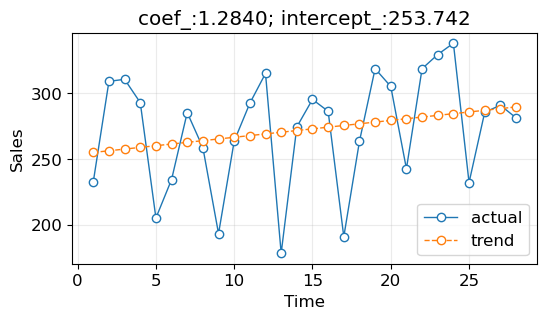

In [7]:
reg = LinearRegression().fit(t_array, sales_array)
# print(tArray)
# print(SalesArray)
# reg.coef_, reg.intercept_

fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(t_array, sales_array, marker='o', 
  markerfacecolor="white", linestyle='-', 
  linewidth=1, label="actual")
ax.plot(t_array, reg.coef_*t_array + reg.intercept_, marker='o',
  markerfacecolor="white", linestyle="--", 
  linewidth=1, label="trend")

ax.set_title(f"coef_:{reg.coef_[0]:.4f}; intercept_:{reg.intercept_:.3f}")
ax.set_xlabel("Time")
ax.set_ylabel("Sales")
ax.grid("on")
ax.legend(loc="best")

plt.show(fig)


## Adjusted seasonal index

The quarterly seasonal indexes for each year must sum to 4, so the median for each quarter must be adjusted to get the final set of seasonal indexes.

### Compute monthly seasonal index

In [8]:
df_seasonal = df.copy()

k1 = 4
df_seasonal["mov_tot_4"] = df_seasonal["Y_t"].rolling(window=k1).sum().shift(-2)

k2 = 2
df_seasonal["mov_tot_2y"] = df_seasonal["mov_tot_4"].rolling(window=k2).sum()

df_seasonal["mov_avg_4_center"] = df_seasonal["mov_tot_2y"] / (k1*k2)

# dividing by the trend
df_seasonal["S_idx"] = df_seasonal["Y_t"] / df_seasonal["mov_avg_4_center"]

#df_seasonal


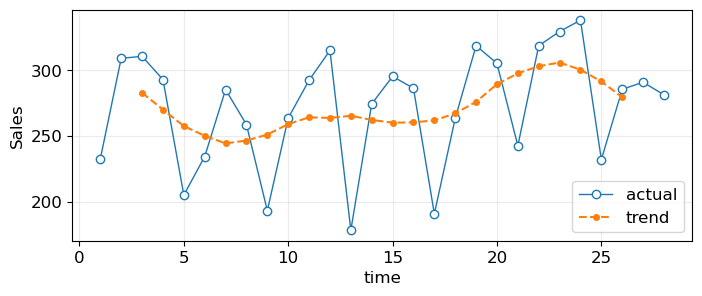

In [9]:
fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(df["t"], df["Y_t"], 
  marker='o', markerfacecolor="white", 
  linestyle='-', linewidth=1, label="actual")
ax.plot(df["t"], df_seasonal["mov_avg_4_center"],
  marker='o', markersize=4, linestyle='--', label="trend")

ax.set_xlabel("time")
ax.set_ylabel("Sales")
ax.grid("on")
ax.legend(loc="best")

plt.show(fig)

In [42]:
# Create the table for montly seasonal index 
# including median and adjusted seasonal index
num_of_years = 7
start_year = 2000
seasonal_idx = df_seasonal["S_idx"].to_numpy()

df_quarter_seasonal = pd.DataFrame(["Q1", "Q2", "Q3", "Q4"], columns={"Quarter"})

for i in range(num_of_years):
  year_key = f"{start_year+i:04d}"
  df_quarter_seasonal[year_key] = seasonal_idx[k1*i:k1*i+k1]

seasonal_idx_median = np.empty(k1)
for i in range(k1):
  row_seasonal_idx = df_quarter_seasonal.iloc[i,1:]
  seasonal_idx_median[i] = row_seasonal_idx.median()

df_quarter_seasonal["Median"] = seasonal_idx_median

median_total = df_quarter_seasonal["Median"].sum()
print(f"multiplier: {k1/median_total}")
df_quarter_seasonal["Adj_S_idx"] = df_quarter_seasonal["Median"] * (k1 / median_total)
df_quarter_seasonal

multiplier: 0.9961455958789731


,Quarter,2000,2001,2002,2003,2004,2005,2006,Median,Adj_S_idx
0,Q1,NaN,0.796080,0.769300,0.671595,0.728383,0.814846,0.796090,0.782690,0.779673
1,Q2,NaN,0.936897,1.017803,1.046711,0.986014,1.051495,1.021368,1.019585,1.015655
2,Q3,1.098074,1.167698,1.106749,1.135226,1.154759,1.077168,NaN,1.120988,1.116667
3,Q4,1.084583,1.049120,1.194958,1.099846,1.054713,1.125364,NaN,1.092215,1.088005


### Plot seasonal indices

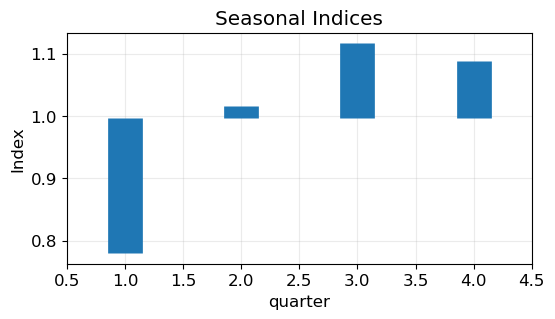

In [124]:
fig, ax = plt.subplots(figsize=(6, 3))

t_month = np.arange(k1) + 1
stem_handler = ax.stem(t_month, df_quarter_seasonal["Adj_S_idx"],
                       bottom=k1/median_total)

stem_handler[0].set_marker(None)
stem_handler[1].set_linewidth(25)
stem_handler[2].set_alpha(0)

ax.set_xlabel("quarter")
ax.set_ylabel("Index")
ax.set_xlim([0.5, 4.5])
ax.set_title("Seasonal Indices")
ax.grid("on")

plt.show(fig)

## Multiplicative decomposition

In [56]:
df_decompose = df.copy()

# I use from the textbook, computing with regression give a different result
# I have checked many times, but it seems textbook use different data
b0 = 261.24071428
b1 = 0.75891909

df_decompose["T_t"] = b0 + df_decompose["t"]*b1
df_decompose["(SCI)_t"] = df_decompose["Y_t"] / df_decompose["T_t"]

# Add a column for adjusted seasonal index
S_idx = np.empty(num_of_years*4)
for i in range(num_of_years):
  S_idx[k1*i:k1*i+k1] = df_quarter_seasonal["Adj_S_idx"]

df_decompose["S_t"] = S_idx

df_decompose["(TCI)_t"] = df_decompose["Y_t"] / df_decompose["S_t"]
df_decompose["(CI)_t"] = df_decompose["(TCI)_t"] / df_decompose["T_t"]

# Cyclical column computed using three-period moving average
# three because we have to centered the data, then the window
# should be an odd number less than the seasonal period.
df_decompose["C_t"] = df_decompose["(CI)_t"].rolling(window=3).mean().shift(-1)

df_decompose["I_t"] = df_decompose["(CI)_t"] / df_decompose["C_t"]

df_decompose

,t,Y_t,T_t,(SCI)_t,S_t,(TCI)_t,(CI)_t,C_t,I_t
0,1,232.7,261.999633,0.888169,0.779673,298.458486,1.139156,NaN,NaN
1,2,309.2,262.758552,1.176746,1.015655,304.433937,1.158607,1.117876,1.036436
2,3,310.7,263.517472,1.179049,1.116667,278.238746,1.055865,1.077827,0.979623
3,4,293.0,264.276391,1.108688,1.088005,269.300313,1.019010,1.022473,0.996614
4,5,205.1,265.035310,0.773859,0.779673,263.059027,0.992543,0.959948,1.033955
5,6,234.4,265.794229,0.881885,1.015655,230.786918,0.868292,0.939892,0.923821
6,7,285.4,266.553148,1.070706,1.116667,255.582034,0.958841,0.905545,1.058855
7,8,258.7,267.312067,0.967783,1.088005,237.774713,0.889502,0.924237,0.962418
8,9,193.2,268.070986,0.720705,0.779673,247.796216,0.924368,0.926556,0.997639
9,10,263.7,268.829905,0.980918,1.015655,259.635282,0.965798,0.953931,1.012439


In [169]:
## write to .csv for 04-example-4.ipynb

df_decompose.to_csv("04-table-04-auto-generated.csv")

## Plot of component analysis

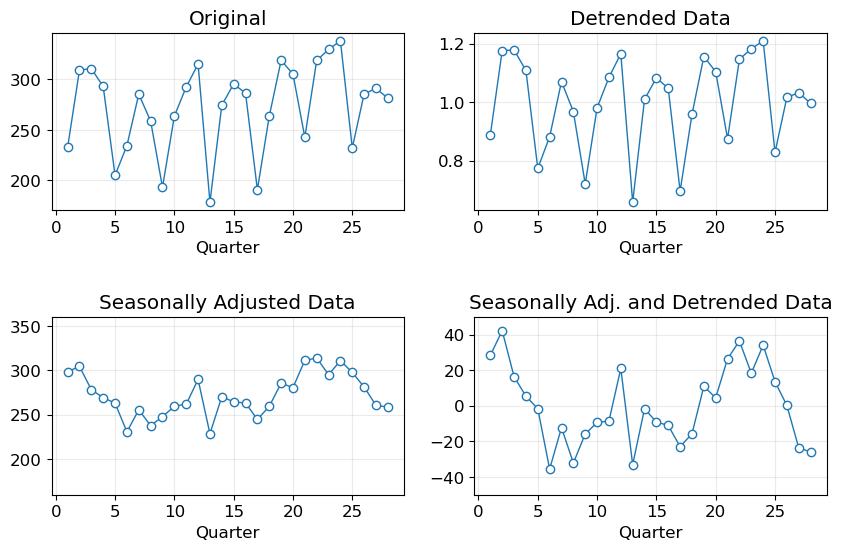

In [83]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

axes[0, 0].plot(df_decompose["t"], df_decompose["Y_t"],
  marker="o", markerfacecolor="white", linestyle="-", 
  linewidth=1)
axes[0, 0].set_xlabel("Quarter")
axes[0, 0].set_title("Original")
axes[0, 0].grid("on")

axes[0, 1].plot(df_decompose["t"], df_decompose["(SCI)_t"],
  marker="o", markerfacecolor="white", linestyle="-", 
  linewidth=1)
axes[0, 1].set_xlabel("Quarter")
axes[0, 1].set_title("Detrended Data")
axes[0, 1].grid("on")

axes[1, 0].plot(df_decompose["t"], df_decompose["(TCI)_t"],
  marker="o", markerfacecolor="white", linestyle="-", 
  linewidth=1)
axes[1, 0].set_ylim([160, 360])
axes[1, 0].set_xlabel("Quarter")
axes[1, 0].set_title("Seasonally Adjusted Data")
axes[1, 0].grid("on")

# (CI)_t from table
# axes[1, 1].plot(df_decompose["t"], df_decompose["(CI)_t"],
#   marker="o", markerfacecolor="white", linestyle="-", 
#   linewidth=1)

# The following lower right plot use the formulation from Minitab
# (CI)_t = Y - (T_t x S_t)
axes[1, 1].plot(df_decompose["t"], df_decompose["Y_t"] - df_decompose["T_t"]*df_decompose["S_t"],
  marker="o", markerfacecolor="white", linestyle="-", 
  linewidth=1)
axes[1, 1].set_ylim([-50, 50])
axes[1, 1].set_xlabel("Quarter")
axes[1, 1].set_title("Seasonally Adj. and Detrended Data")
axes[1, 1].grid("on")

plt.subplots_adjust(hspace=0.6)
plt.show(fig)

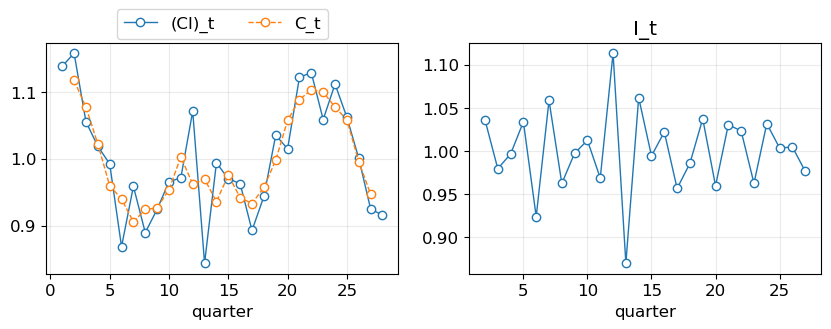

In [167]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))

axes[0].plot(df_decompose["t"], df_decompose["(CI)_t"], 
  marker='o', markerfacecolor="white", linestyle="-", 
  linewidth=1, label="(CI)_t")
axes[0].plot(df_decompose["t"], df_decompose["C_t"], 
  marker='o', markerfacecolor="white", linestyle="--",
  linewidth=1, label="C_t")

axes[0].set_xlabel("quarter")
axes[0].grid("on")
axes[0].legend(loc="best")

axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.18),
          ncol=3, fancybox=True, shadow=False)

axes[1].plot(df_decompose["t"], df_decompose["I_t"],
  marker='o', markerfacecolor="white", linestyle="-", 
  linewidth=1)
axes[1].set_xlabel("quarter")
axes[1].set_title("I_t")
axes[1].grid("on")


plt.show(fig)

Examination of the $I$ column shows that there were some large changes in the irregular components.  
The irregular index dropped from 111.4% in the fourth quarter of 2002 to 87%
in the first quarter of 2003 and then increased to 106.2% in the second quarter of 2003.   
This behaviour results from the unusually low sales in the first quarter of 2003.

## Plot of seasonal analysis

In [138]:
SCI_t = df_decompose["(SCI)_t"].to_numpy()
SCI_t = np.reshape(SCI_t, (num_of_years, -1))  # collect each quarter (by season)

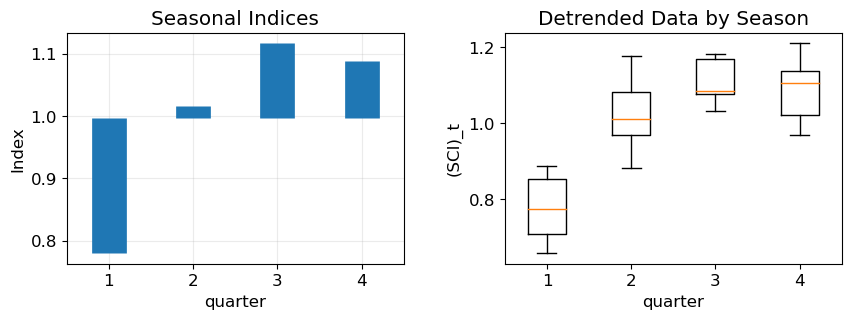

In [147]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))

t_month = np.arange(k1) + 1
stem_handler = axes[0].stem(t_month, df_quarter_seasonal["Adj_S_idx"],
                       bottom=k1/median_total)

stem_handler[0].set_marker(None)
stem_handler[1].set_linewidth(25)
stem_handler[2].set_alpha(0)

axes[0].set_xlabel("quarter")
axes[0].set_ylabel("Index")
axes[0].set_xlim([0.5, 4.5])
axes[0].set_title("Seasonal Indices")
axes[0].grid("on")

axes[1].boxplot(SCI_t)
axes[1].set_xlabel("quarter")
axes[1].set_ylabel("(SCI)_t")
axes[1].set_title("Detrended Data by Season")

plt.subplots_adjust(wspace=0.3)
plt.show(fig)
